In [1]:
%matplotlib inline

import numpy as np
import nibabel as nb
import pandas as pd
import sklearn
import pylab as plt
from nilearn import plotting
from nilearn.input_data import NiftiMasker


In [2]:
def pred_real_scatter(y_test, y_test_predicted):
    plt.scatter(y_test, y_test_predicted)
    plt.plot([10,80],[10,80], 'k')
    plt.xlabel('real')
    plt.ylabel('predicted')
    ax = plt.gca()
    ax.set_aspect('equal')

In [3]:
brain_mask_file = '/Users/franzliem/Dropbox/Workspace/LeiCA/anat_templates/\
cpac_image_resources/MNI_3mm/MNI152_T1_3mm_brain_mask.nii.gz'
brain_data_file_template = '/Users/franzliem/Dropbox/LeiCA/00_learning_test/%s_merge.nii.gz'
df_file = '/Users/franzliem/Dropbox/LeiCA/00_learning_test/df_used.csv'
subject_list = '/Users/franzliem/Dropbox/LeiCA/00_learning_test/subject_list.txt'
metrics_list = ['alff', 'reho', 'falff']

df = pd.read_csv(df_file, dtype='object')
df = df.set_index(df.subject_id)

s = pd.read_csv(subject_list, header=None, dtype=object)
s.columns=['subject_id']
assert np.all(s.subject_id == df.subject_id), "df not in right order"

## extracting data with nilearn

/Users/franzliem/Dropbox/LeiCA/00_learning_test/alff_merge.nii.gz
/Users/franzliem/Dropbox/LeiCA/00_learning_test/reho_merge.nii.gz
/Users/franzliem/Dropbox/LeiCA/00_learning_test/falff_merge.nii.gz


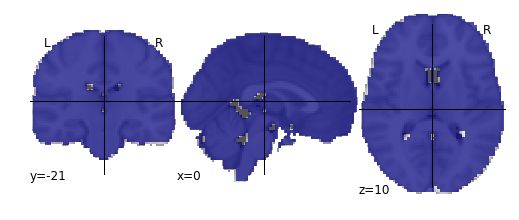

In [4]:

plotting.plot_roi(brain_mask_file)
masker = NiftiMasker(mask_img=brain_mask_file)


brain_data_list = []
for m in metrics_list:
    brain_data_file = (brain_data_file_template)%m
    print brain_data_file
    brain_data_list.append(masker.fit_transform(brain_data_file))


In [18]:
dict_2d=dict()
for i,m in enumerate(metrics_list):
    dict_2d[m]=brain_data_list[i]


X = np.hstack([dict_2d[m] for m in metrics_list])
#X = dict_2d['alff']
print X.shape
y = df.age.values.astype(np.float)
#y = df.mean_FD_Power.values.astype(np.float)


assert X.shape[0] == y.shape[0], "shape error"

(257, 203247)


# women only

In [ ]:
y = y[(df.sex=='F').values].astype(np.float)
X = X[(df.sex=='F').values,:]

print X.shape, y.shape

## PCA

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.999) #, whiten=True)
X_trans = pca.fit_transform(X)
print pca.n_components_

255


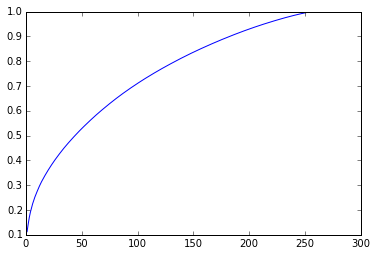

In [20]:
cum_var = np.array([pca.explained_variance_ratio_[:i+1].sum() for i in range(pca.explained_variance_ratio_.shape[0])])
plt.plot(range(1,cum_var.shape[0]+1),cum_var)

## learning

In [55]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X = X_trans
#standard_scaler = StandardScaler()
#X = standard_scaler.fit_transform(X)
#minmax = MinMaxScaler(feature_range=(-1,1))
#X=minmax.fit_transform(X)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 11 µs
CV scores:
min: -10.374, mean: -8.923, max: -7.971


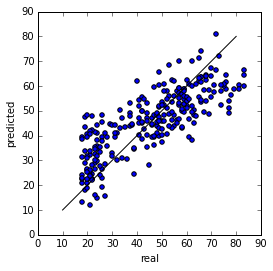

In [57]:
%time
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import cross_val_score, cross_val_predict

regression_model = SVR(kernel='linear', C=6e-7)
cv_scores = cross_val_score(regression_model, X, y, cv=5, n_jobs=4, scoring='mean_absolute_error')

print("CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    cv_scores.min(), cv_scores.mean(), cv_scores.max()))

y_predicted = cross_val_predict(regression_model, X, y, cv=5, n_jobs=4)
pred_real_scatter(y, y_predicted)

CV scores:
min: -11.947, mean: -9.593, max: -7.830


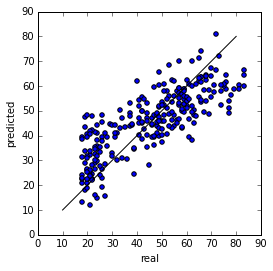

In [43]:
X = X_trans
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error
from sklearn.cross_validation import cross_val_score, cross_val_predict

regression_model = NuSVR(kernel='linear')
cv_scores = cross_val_score(regression_model, X, y, cv=5, n_jobs=4, scoring='mean_absolute_error')

print("CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    cv_scores.min(), cv_scores.mean(), cv_scores.max()))

y_predicted_2 = cross_val_predict(regression_model, X, y, cv=5, n_jobs=4)
pred_real_scatter(y, y_predicted)

## GS

In [53]:
%%time

from sklearn.grid_search import GridSearchCV

regression_model = SVR(kernel='linear')

params = {
    'C': [.001,.01,1,10,100] #np.arange(1e-7,1e-6,1e-7) , #np.arange(.01,.1,.01) 
    #'epsilon': [.00001,.001,.01,1] #np.arange(5,15,1) 
}
gs = GridSearchCV(regression_model, params, cv=5, scoring='r2', n_jobs=5)
gs.fit(X, y)

CPU times: user 120 ms, sys: 43.5 ms, total: 163 ms
Wall time: 422 ms


In [54]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

[mean: 0.07400, std: 0.03691, params: {'C': 1},
 mean: 0.06775, std: 0.04663, params: {'C': 10},
 mean: 0.06122, std: 0.04672, params: {'C': 100},
 mean: -0.04846, std: 0.05645, params: {'C': 0.01},
 mean: -0.05019, std: 0.05710, params: {'C': 0.001}]

In [58]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

[mean: -8.89881, std: 0.98317, params: {'C': 7.9999999999999996e-07},
 mean: -8.90107, std: 0.96190, params: {'C': 6.9999999999999997e-07},
 mean: -8.90149, std: 0.99151, params: {'C': 8.9999999999999996e-07},
 mean: -8.91833, std: 0.94234, params: {'C': 5.9999999999999997e-07},
 mean: -8.95070, std: 0.90986, params: {'C': 4.9999999999999998e-07},
 mean: -9.03966, std: 0.86755, params: {'C': 3.9999999999999998e-07},
 mean: -9.17522, std: 0.81336, params: {'C': 2.9999999999999999e-07},
 mean: -9.35198, std: 0.84035, params: {'C': 1.9999999999999999e-07},
 mean: -9.85434, std: 0.82449, params: {'C': 9.9999999999999995e-08}]

In [53]:
np.arange(1e-7,1e-6,1e-7)

array([  1.00000000e-07,   2.00000000e-07,   3.00000000e-07,
         4.00000000e-07,   5.00000000e-07,   6.00000000e-07,
         7.00000000e-07,   8.00000000e-07,   9.00000000e-07])

In [50]:
np.arange(1e-6,1e-5,1e-6) 

array([  1.00000000e-06,   2.00000000e-06,   3.00000000e-06,
         4.00000000e-06,   5.00000000e-06,   6.00000000e-06,
         7.00000000e-06,   8.00000000e-06,   9.00000000e-06])

In [56]:
np.sqrt(.62)

0.78740078740118113

In [79]:
tt=pca.inverse_transform(X_trans)

In [87]:
X.ravel().shape

(52234479,)